# Kriging Walkthrough
Video Tutorial: https://youtu.be/mhveiX_d9Q8
Data Source: https://www.epa.gov/outdoor-air-quality-data/download-daily-data


## Packages

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pykrige.ok import OrdinaryKriging

## Read in Houston air quality data

In [32]:
df = pd.read_csv('water quality parameter.csv')
df = df[['Lat(Dec)','Long(Dec)','Iron']]
df

,Lat(Dec),Long(Dec),Iron
0,23.72,90.43,0.13
1,23.72,90.44,0.51
2,23.72,90.41,0.59
3,23.72,90.42,1.00
4,23.71,90.42,0.61
...,...,...,...
140,23.86,90.41,0.80
141,23.88,90.39,0.52
142,23.86,90.40,0.69
143,23.87,90.41,1.00


In [33]:
# Extract the necessary columns
latitude = df['Lat(Dec)'].values
longitude = df['Long(Dec)'].values
aqi_value = df['Iron'].values

# Setup arrays and grid

In [34]:

# Define the grid for interpolation
gridx = np.linspace(min(longitude) -.35, max(longitude) +.35, 100)
gridy = np.linspace(min(latitude) -.10, max(latitude) + .10, 100)

## Ordinary Kriging

Plotting Enabled

Initializing variogram model...
Coordinates type: 'geographic' 

Using 'spherical' Variogram Model
Partial Sill: 0.025643248121525238
Full Sill: 0.09413737443124558
Range: 0.050279267902237926
Nugget: 0.06849412630972034 



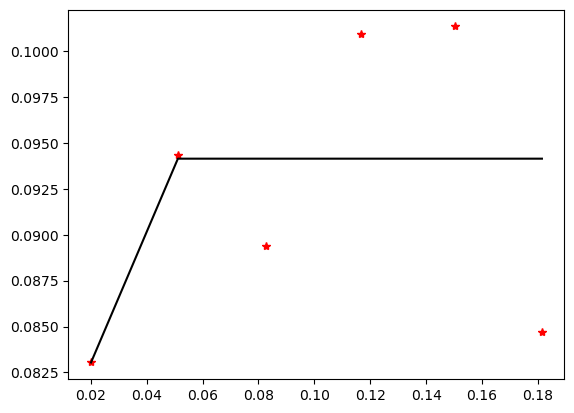

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...



In [35]:
# Perform Ordinary Kriging using the spherical variogram model
OK = OrdinaryKriging(longitude, 
                     latitude, 
                     aqi_value, 
                     variogram_model='spherical', 
                     coordinates_type='geographic', 
                     verbose=True, 
                     enable_plotting=True)
z_interp, ss = OK.execute('grid', gridx, gridy)

## Create overlay image of kriging interpolated values

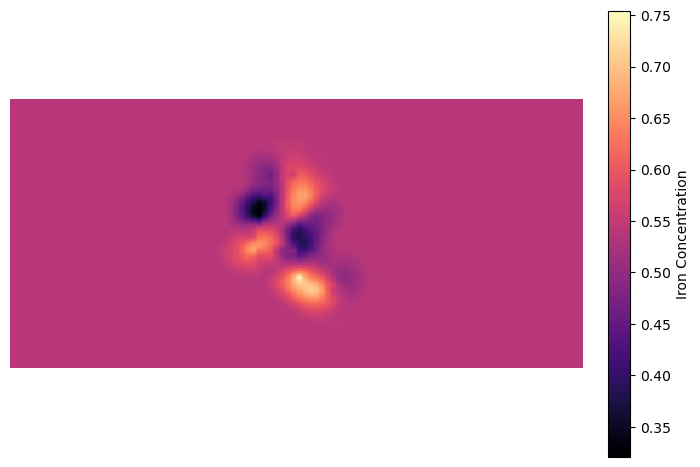

In [36]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Assuming z_interp, gridx, and gridy are already defined

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 8))

# Plot the interpolation results
cax = ax.imshow(z_interp, 
                extent=[gridx.min(), 
                        gridx.max(), 
                        gridy.min(), 
                        gridy.max()], 
                origin='lower', 
                cmap='magma', 
                alpha=1)

# Add color bar
cbar = fig.colorbar(cax, ax=ax, orientation='vertical', fraction=0.036, pad=0.04)
cbar.set_label('Iron Concentration')

# Remove axes
ax.axis('off')

# Save the image
fig.savefig('kriging_interpolation.png', bbox_inches='tight', pad_inches=0, transparent=True)
plt.close(fig)

# Load the image with PIL
image = Image.open('kriging_interpolation.png')

fig

## Create base map with overlayed interpolated data


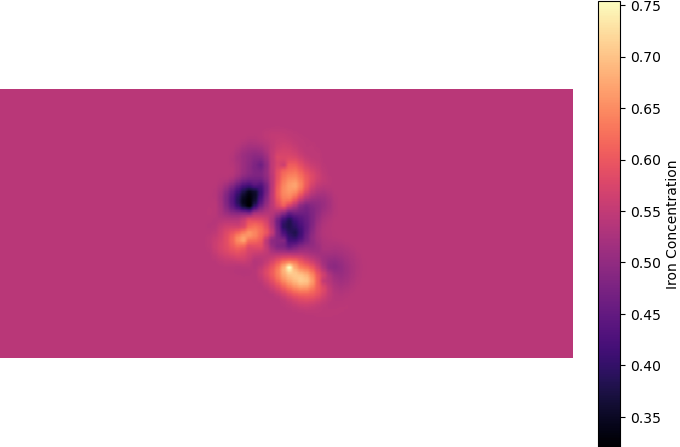

In [37]:
import folium
from folium.raster_layers import ImageOverlay

# Create a base map centered on Dhaka
m = folium.Map(location=[23.81, 90.41], zoom_start=12)  # Adjust zoom level as needed

# Define the bounds where the image will be placed
bounds = [[gridy.min(), gridx.min()], [gridy.max(), gridx.max()]]

# Add the image overlay (Kriging interpolation result)
image_overlay = ImageOverlay(
    image='kriging_interpolation.png',  # Make sure the image file exists in the directory
    bounds=bounds,
    opacity=0.7,
    interactive=True,
    cross_origin=False,
    zindex=1,
)

image_overlay.add_to(m)

# Add points for the measuring stations
for lat, lon in zip(latitude, longitude):
    folium.CircleMarker(
        location=[lat, lon],
        radius=3,  # Slightly larger for visibility
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=1
    ).add_to(m)

# Save the map to an HTML file
m.save('dhaka_kriging_map.html')

# Display the map
m

